In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import astropy.convolution as cv
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import os
import pymc3 as pm

In [3]:
psd = pd.read_table('data/tic44162736.spoc.ps', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [53]:
mask = psd['freq'] > 50
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
freq = np.linspace(min(full_freq), max(full_freq), 1000)
freq = full_freq
smoothed_power = cv.convolve(power, cv.Box1DKernel(30 / (full_freq[1] - full_freq[0])))
itrp_power = np.interp(freq, full_freq, smoothed_power)

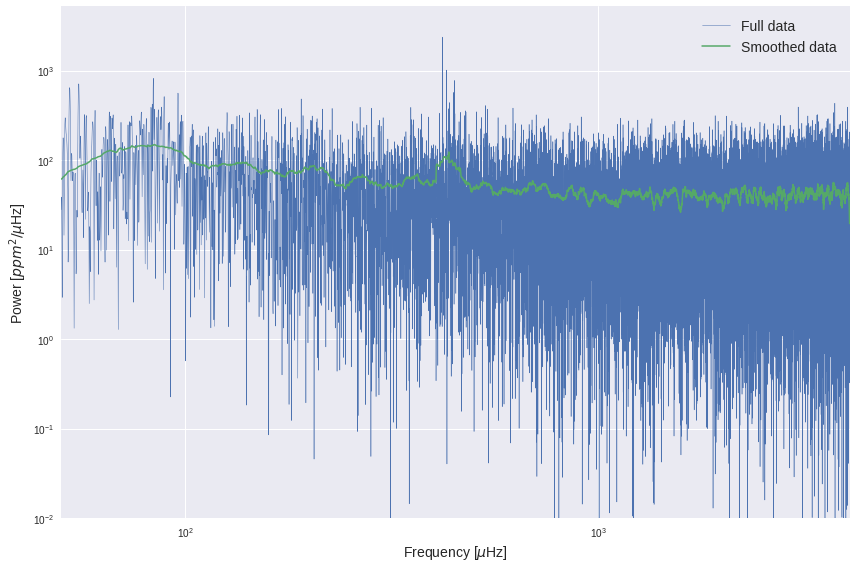

In [130]:
plt.loglog(full_freq, power, lw=.5, alpha=1, c='C0')
plt.loglog(freq, itrp_power, 'C1', lw=1.5)
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power [$ppm^2 /\mu$Hz]')
plt.tight_layout();
plt.legend(['Full data', 'Smoothed data']);
# plt.savefig('figs/psd_pre.pdf')

In [134]:
def response(freq, v_nyq=8333.33):
    theta = np.pi / 2 * freq / v_nyq
    return pm.math.sin(theta)**2 / theta**2
    
def harvey(freq, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4)

def envelope(freq, H0, v_max, s):
    try:
        return H0 * pm.math.exp(-(v_max - freq)**2 / (2*s**2))
    except:
        return H0 * np.exp(-(v_max - freq)**2 / (2*s**2))

def background(freq, W, harvs):
    try:
        return W + response(freq) * pm.math.sum(harvs, axis=0) 
    except:
        return W + response(freq) * np.sum(harvs, axis=0) 

def likelihood(freq, W, harvs, env):
    return background(freq, W, harvs) + response(freq) * env

In [135]:
with pm.Model() as background_model:
        k = 3
        
        W = pm.Uniform('W', lower=1, upper=100)
        a = pm.Uniform('a', lower=10, upper=150, shape=k)
        b = pm.Uniform('b', lower=[1, 20, 100], upper=[10, 210, 700], shape=k)
        
        harvs = [harvey(freq, a[i], b[i]) for i in range(k)]
        
        H0 = pm.Uniform('H0', lower=5, upper=100)
        v_max = pm.Uniform('v_max', lower=200, upper=600)
        s = pm.Uniform('s', lower=10, upper=80)
        
        env = envelope(freq, H0, v_max, s)
        like = likelihood(freq, W, harvs, env)
        y = pm.Exponential('obs', lam=1/like, observed=itrp_power)

In [136]:
with background_model:
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, v_max, H0, b, a, W]
Sampling 4 chains: 100%|██████████| 10000/10000 [05:15<00:00, 31.66draws/s]


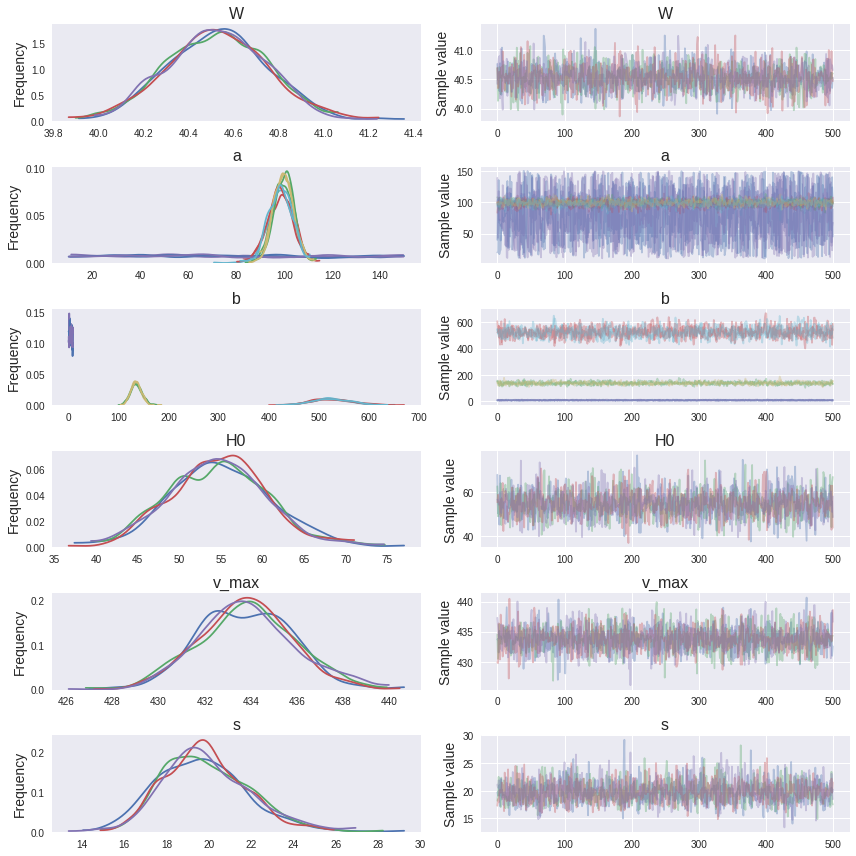

In [137]:
pm.traceplot(trace);
# plt.savefig('figs/trace1.pdf')

In [138]:
summ = pm.summary(trace)
# summ.to_csv('trace_summary.csv')
summ

mean         sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
W       40.526262   0.222343  0.004335   40.086747   40.935823  2938.337400   
a__0    78.383896  40.132277  0.700333   11.531736  142.941185  3002.543093   
a__1    99.662929   4.223327  0.097640   91.968140  108.353479  1613.368775   
a__2    98.208236   5.152505  0.130655   88.921826  109.025304  1409.014427   
b__0     5.434087   2.556148  0.043044    1.296675    9.733749  3218.110958   
b__1   135.843669  10.832628  0.267731  115.170838  157.046648  1589.101310   
b__2   525.277249  39.272507  0.997105  456.781383  609.319580  1564.557583   
H0      54.757706   6.015597  0.118626   43.255660   67.096969  2629.199626   
v_max  433.769508   2.042916  0.033777  429.747011  437.756153  4001.115340   
s       19.802410   2.021406  0.047695   16.197927   23.893721  1920.426043   

           Rhat  
W      0.999445  
a__0   0.999099  
a__1   1.000302  
a__2   1.001101  
b__0   0.999762  
b__1   1.000613  
b__2   1.001854  
H0     0.999427  
v_max  0.999276  
s      1.001133

In [139]:
ppc = pm.sample_ppc(trace, 1000, background_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:07<00:00, 139.00it/s]


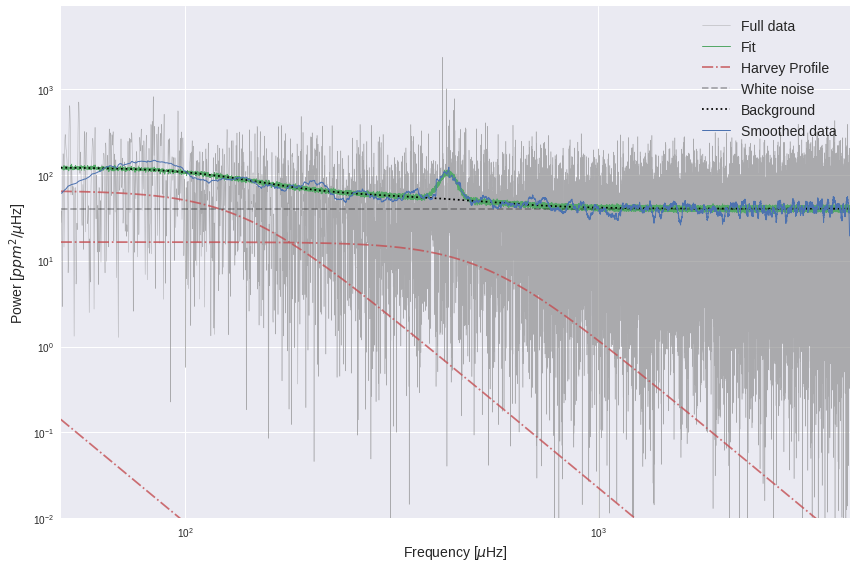

In [140]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5', label='Full data')
plt.loglog(freq, post, 'C1', lw=1, label='Fit')
a = trace['a'].mean(axis=0)
b = trace['b'].mean(axis=0)
harveys = [harvey(full_freq, a[i], b[i]) for i in range(k)]
hls = [plt.loglog(full_freq, harv, 'C2-.', alpha=.8) for harv in harveys]
hls[0][0].set_label('Harvey Profile')
plt.axhline(trace['W'].mean(), c='k', alpha=.3, ls='--', label='White noise')
theta = theta = np.pi / 2 * full_freq / 8333.33
response = np.sin(theta)**2 / theta**2
back = trace['W'].mean() + response * np.sum(harveys, axis=0)
plt.loglog(freq, back, 'k:', ms=0.2, label='Background')
plt.loglog(freq, itrp_power, 'C0', lw=1, label='Smoothed data')
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power [$ppm^2 /\mu$Hz]')
plt.tight_layout()
plt.legend();
# plt.savefig('figs/psd_fit.pdf')

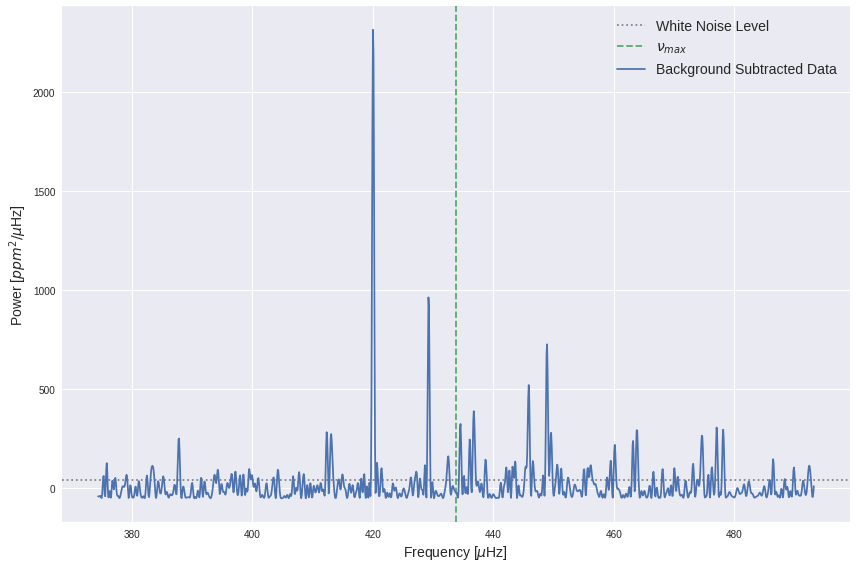

In [141]:
s = trace['s'].mean()
v_max = trace['v_max'].mean()
mask = (full_freq > (v_max - 3 * s)) & (full_freq < (v_max + 3 * s))
subfreq = full_freq[mask]
subpower = (power - back)[mask]
plt.axhline(trace['W'].mean(), c='0.5', ls=':', label='White Noise Level')
plt.axvline(v_max, c='C1', ls='--', label=r'$\nu_{max}$')
# [plt.axvline((v_max - i * s), c='.5', ls='-.', alpha=.8) for i in range(-3, 4) if i != 0]
plt.plot(subfreq, subpower, label='Background Subtracted Data')
plt.xlabel(r'Frequency [$\mu$Hz]')
plt.ylabel('Power [$ppm^2 /\mu$Hz]')
plt.tight_layout()
plt.legend();